In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import random
import pandas as pd
import pytorch_lightning as pl

from dtaidistance import dtw
from frechetdist import frdist

In [2]:
DATASET_PATH = "../Datasets/LUDB/i_ii_avf_v4_v5_v6_leads_3_complexes.json"

In [3]:
DATA = pd.read_json(DATASET_PATH)

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
      super(Discriminator, self).__init__()

      self.discriminator_input_size = discriminator_input_size
      self.model = torch.nn.Sequential(
          torch.nn.Linear(self.discriminator_input_size, 512),
          torch.nn.LeakyReLU(0.2, inplace=True),
          torch.nn.Linear(512, 256),
          torch.nn.LeakyReLU(0.2, inplace=True),
          torch.nn.Linear(256, 1),
          torch.nn.Sigmoid(),
      )

    def forward(self, x):
        out = self.model(x)
        return out

In [5]:
class Generator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
      super(Generator, self).__init__()

      self.discriminator_input_size = discriminator_input_size

      self.model = torch.nn.Sequential(
          torch.nn.Linear(100, 128),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(128, 256),
          torch.nn.BatchNorm1d(256, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(256, 512),
          torch.nn.BatchNorm1d(512, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(512, 1024),
          torch.nn.BatchNorm1d(1024, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(1024, self.discriminator_input_size),
          torch.nn.Tanh(),
      )

    def forward(self, x):
        out = self.model(x)
        return out

In [6]:
class DenoisedGenerator(torch.nn.Module):
    def __init__(self, discriminator_input_size):
      super(DenoisedGenerator, self).__init__()

      self.discriminator_input_size = discriminator_input_size

      self.model = torch.nn.Sequential(
          torch.nn.Linear(100, 128),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(128, 256),
          torch.nn.BatchNorm1d(256, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(256, 512),
          torch.nn.BatchNorm1d(512, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(512, 1024),
          torch.nn.BatchNorm1d(1024, 0.8),
          torch.nn.LeakyReLU(0.2, inplace=True),

          torch.nn.Linear(1024, self.discriminator_input_size),
          torch.nn.Tanh(),
      )
      self.convs_1d = torch.nn.Sequential(
          torch.nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4),
          torch.nn.Tanh(),
          torch.nn.Conv1d(16, 16, kernel_size=9, stride=1, padding=4),
          torch.nn.Tanh(),
          torch.nn.Conv1d(16, 1, kernel_size=9, stride=1, padding=4))

    def forward(self, x):
        out = self.model(x)
        out = out.unsqueeze(1)
        out = self.convs_1d(out)
        out = out.squeeze()
        return out

In [7]:
class GAN(pl.LightningModule):
    def __init__(self,
                 discriminator_input_size=256,
                 lr=0.0002,
                 b1=0.5,
                 b2=0.999,
                 is_denoised = False):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.preds_stage = {"train": {"g_loss": [], "d_loss": []}}

        self.discriminator_input_size = discriminator_input_size
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.loss = torch.nn.BCELoss()

        self.generator = Generator(discriminator_input_size)
        self.discriminator = Discriminator(discriminator_input_size)
        
        

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(),
                                 lr=self.lr,
                                 betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(),
                                 lr=self.lr,
                                 betas=(self.b1, self.b2))
        return [opt_g, opt_d], []

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        optg, optd = self.optimizers()

        noise = torch.normal(0, 1, size=(imgs.shape[0], 100), device=self.device)
        fake_inputs = self.generator(noise)
        fake_outputs = self.discriminator(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1], device=self.device)
        g_loss = self.loss(fake_outputs, fake_targets)
        self.preds_stage['train']['g_loss'].append(g_loss.detach().cpu())
        optg.zero_grad()
        g_loss.backward()
        optg.step()


        real_outputs = self.discriminator(imgs)
        real_label = torch.ones(imgs.shape[0], 1, device=self.device)
        noise = torch.normal(0, 1, size=(imgs.shape[0], 100), device=self.device)
        fake_inputs = self.generator(noise)
        fake_outputs = self.discriminator(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1, device=self.device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        d_loss = self.loss(outputs, targets)
        self.preds_stage['train']['d_loss'].append(d_loss.detach().cpu())
        optd.zero_grad()
        d_loss.backward()
        optd.step()

    def on_train_epoch_end(self):
        g_loss = self.preds_stage['train']['g_loss']
        g_loss = torch.stack(g_loss)
        g_loss = np.mean([x.item() for x in g_loss])

        d_loss = self.preds_stage['train']['d_loss']
        d_loss = torch.stack(d_loss)
        d_loss = np.mean([x.item() for x in d_loss])

        metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss
        }
        self.log_dict(metrics, prog_bar=True, on_epoch=True, on_step=False)

        self.preds_stage['train']['g_loss'].clear()
        self.preds_stage['train']['d_loss'].clear()

In [8]:
class DenoisedGAN(pl.LightningModule):
    def __init__(self,
                 discriminator_input_size=256,
                 lr=0.0002,
                 b1=0.5,
                 b2=0.999,
                 is_denoised = False):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        self.preds_stage = {"train": {"g_loss": [], "d_loss": []}}

        self.discriminator_input_size = discriminator_input_size
        self.lr = lr
        self.b1 = b1
        self.b2 = b2

        self.loss = torch.nn.BCELoss()

        self.generator = DenoisedGenerator(discriminator_input_size)
        self.discriminator = Discriminator(discriminator_input_size)
        
        

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(),
                                 lr=self.lr,
                                 betas=(self.b1, self.b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(),
                                 lr=self.lr,
                                 betas=(self.b1, self.b2))
        return [opt_g, opt_d], []

    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        optg, optd = self.optimizers()

        noise = torch.normal(0, 1, size=(imgs.shape[0], 100), device=self.device)
        fake_inputs = self.generator(noise)
        fake_outputs = self.discriminator(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1], device=self.device)
        g_loss = self.loss(fake_outputs, fake_targets)
        self.preds_stage['train']['g_loss'].append(g_loss.detach().cpu())
        optg.zero_grad()
        g_loss.backward()
        optg.step()


        real_outputs = self.discriminator(imgs)
        real_label = torch.ones(imgs.shape[0], 1, device=self.device)
        noise = torch.normal(0, 1, size=(imgs.shape[0], 100), device=self.device)
        fake_inputs = self.generator(noise)
        fake_outputs = self.discriminator(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1, device=self.device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        d_loss = self.loss(outputs, targets)
        self.preds_stage['train']['d_loss'].append(d_loss.detach().cpu())
        optd.zero_grad()
        d_loss.backward()
        optd.step()

    def on_train_epoch_end(self):
        g_loss = self.preds_stage['train']['g_loss']
        g_loss = torch.stack(g_loss)
        g_loss = np.mean([x.item() for x in g_loss])

        d_loss = self.preds_stage['train']['d_loss']
        d_loss = torch.stack(d_loss)
        d_loss = np.mean([x.item() for x in d_loss])

        metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss
        }
        self.log_dict(metrics, prog_bar=True, on_epoch=True, on_step=False)

        self.preds_stage['train']['g_loss'].clear()
        self.preds_stage['train']['d_loss'].clear()

In [9]:
def arith_mean(f, buffer_size=10):
    if not hasattr(arith_mean, "buffer"):
        arith_mean.buffer = [f] * buffer_size

    arith_mean.buffer = arith_mean.buffer[1:]
    arith_mean.buffer.append(f)

    mean = 0
    for e in arith_mean.buffer: mean += e
    mean /= len(arith_mean.buffer)

    return mean

In [10]:
# мешьше - лучше
def average_dynamic_time_warping(real_sample, generating_ecg):
    lenght = len(generating_ecg)
    results = [dtw.distance(real_sample, i) for i in generating_ecg]
    return sum(results)/lenght

In [11]:
def calculate_average_dynamic_time_warping(real_samples, generated_ecg):
    results = []
    for sample in real_samples:
        results.append(average_dynamic_time_warping(sample, generated_ecg))
    return sum(results)/len(real_samples)

In [12]:
# меньше - лучше
def average_fretchet_distance(real_sample, generated_ecg):
    lenght = len(generated_ecg)
    results = []
    q = list(zip(real_sample, range(len(real_sample))))
    for i in generated_ecg:
        p = list(zip(i, range(len(i))))
        results.append(frdist(q, p))
    return sum(results)/lenght

In [13]:
def calculate_average_fretchet_distance(real_samples, generated_ecg):
    results = []
    for sample in real_samples:
        results.append(average_fretchet_distance(sample, generated_ecg))
    return sum(results)/len(real_samples)

In [14]:
undenoised_generator = GAN.load_from_checkpoint("../Models/FewComplexes/Lightning/UnDenoised/epoch=999_g_loss=3.11_d_loss=0.18.ckpt").cpu()
denoised_generator = DenoisedGAN.load_from_checkpoint("../Models/FewComplexes/Lightning/Denoised/epoch=999_g_loss=4.92_d_loss=0.10.ckpt").cpu()
undenoised_generator.eval()
denoised_generator.eval()
num_samples = 10
buffer_size = 5
noise = torch.normal(0, 1, size=(num_samples, 100))
ludb_samples = random.choices(DATA["esg"], k=num_samples)
undenoised_ecg = undenoised_generator(noise).detach().cpu()
denoised_ecg = denoised_generator(noise).detach().cpu()
filtred_undenoised_ecg = [[arith_mean(j, buffer_size) for j in i] for i in undenoised_ecg]
filtred_denoised_ecg = [[arith_mean(j, buffer_size) for j in i] for i in denoised_ecg]

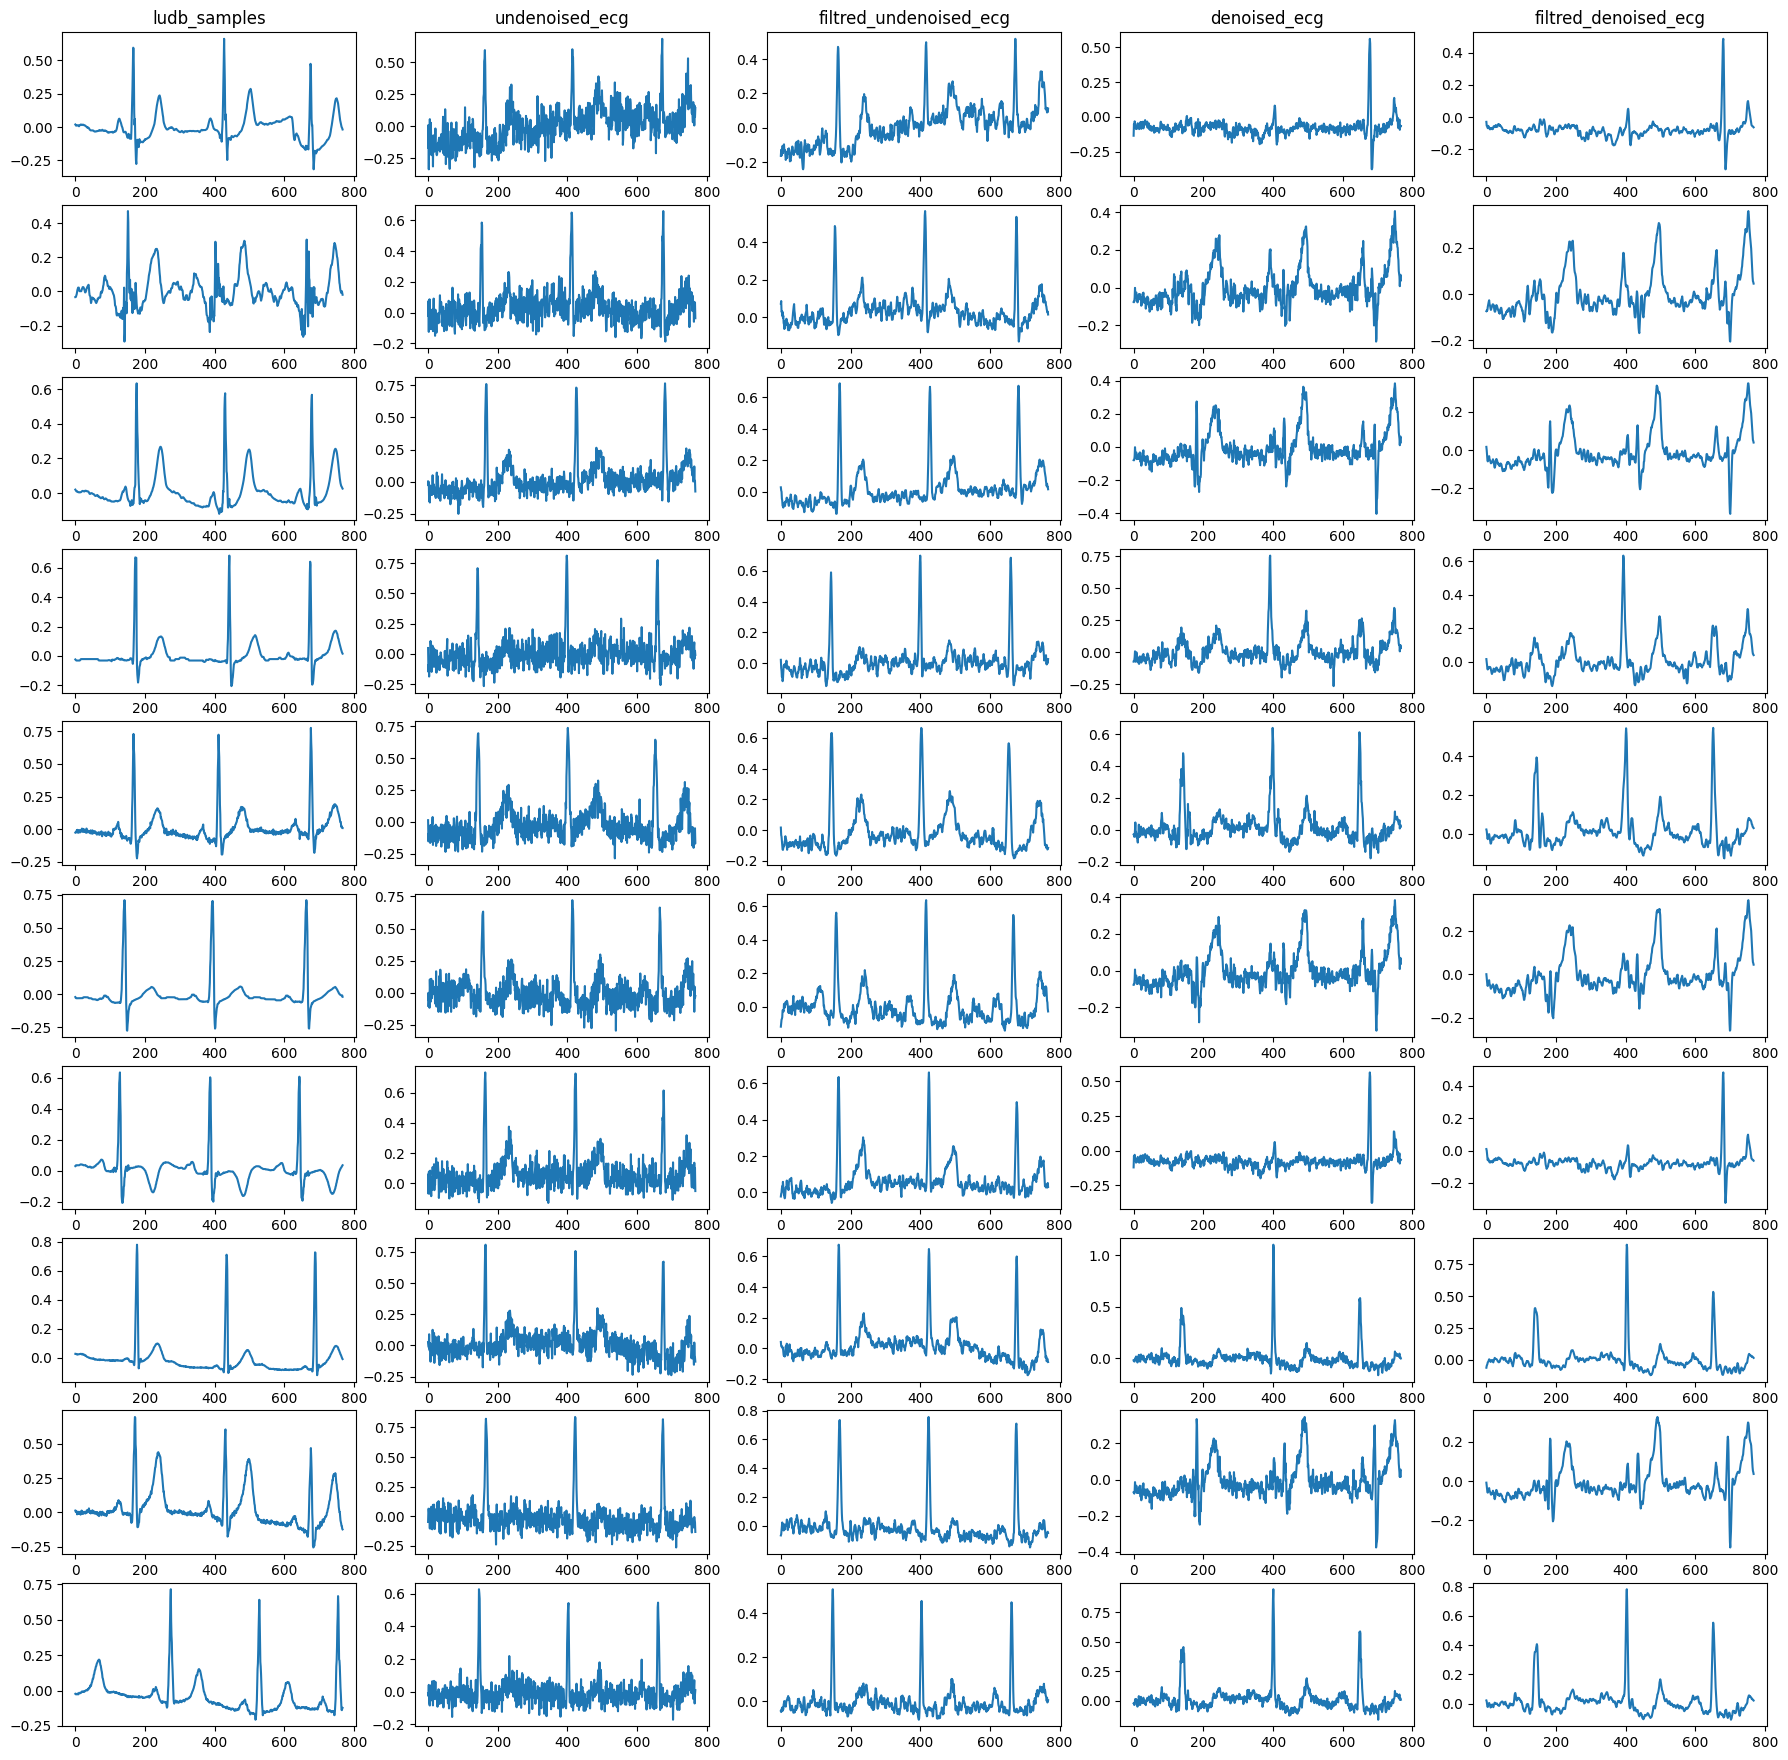

In [15]:
n_cols = 5
n_rows = num_samples

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22, 22))

axes[0, 0].set_title(f"ludb_samples")
axes[0, 1].set_title(f"undenoised_ecg")
axes[0, 2].set_title(f"filtred_undenoised_ecg")
axes[0, 3].set_title(f"denoised_ecg")
axes[0, 4].set_title(f"filtred_denoised_ecg")


for i in range(n_rows):
    axes[i, 0].plot(ludb_samples[i])
    axes[i, 1].plot(undenoised_ecg[i])
    axes[i, 2].plot(filtred_undenoised_ecg[i])
    axes[i, 3].plot(denoised_ecg[i])
    axes[i, 4].plot(filtred_denoised_ecg[i])

In [16]:
undenoised_generator = GAN.load_from_checkpoint("../Models/FewComplexes/Lightning/UnDenoised/epoch=1999_g_loss=6.64_d_loss=0.12.ckpt").cpu()
denoised_generator = DenoisedGAN.load_from_checkpoint("../Models/FewComplexes/Lightning/Denoised/epoch=1999_g_loss=8.23_d_loss=0.10.ckpt").cpu()
undenoised_generator.eval()
denoised_generator.eval()
num_samples = 5
buffer_size = 5
noise = torch.normal(0, 1, size=(num_samples, 100))
ludb_samples = random.choices(DATA["esg"], k=num_samples)
undenoised_ecg = undenoised_generator(noise).detach().cpu()
denoised_ecg = denoised_generator(noise).detach().cpu()
filtred_undenoised_ecg = [[arith_mean(j, buffer_size) for j in i] for i in undenoised_ecg]
filtred_denoised_ecg = [[arith_mean(j, buffer_size) for j in i] for i in denoised_ecg]

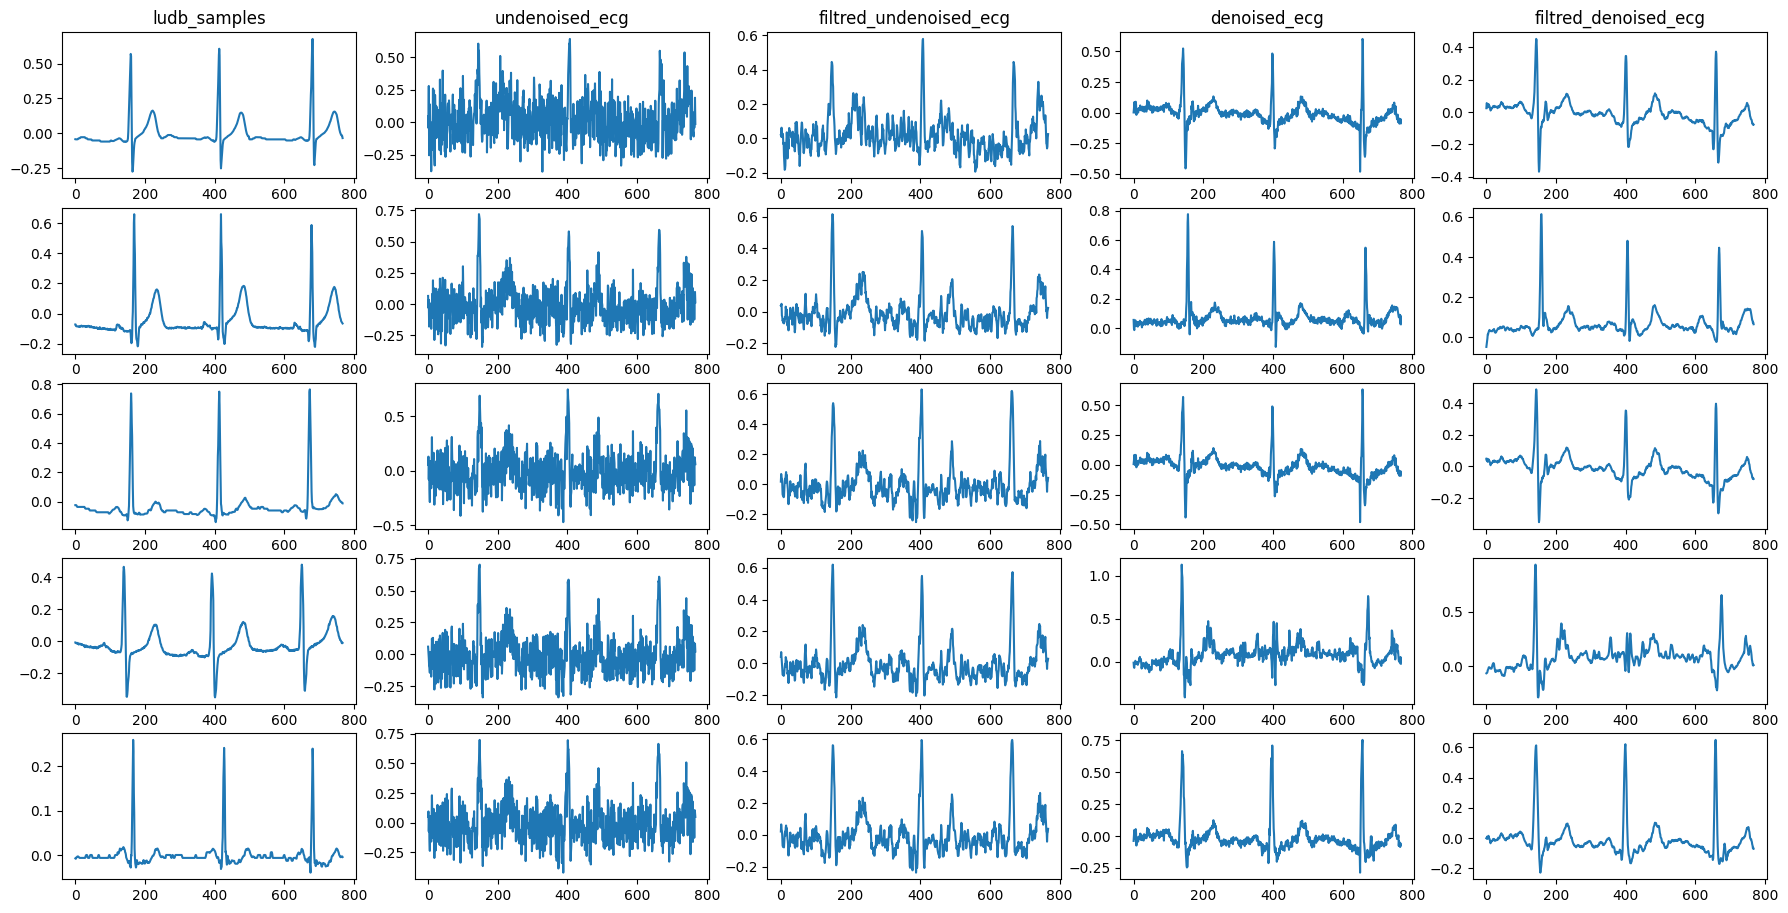

In [17]:
n_cols = 5
n_rows = num_samples

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22, 11))

axes[0, 0].set_title(f"ludb_samples")
axes[0, 1].set_title(f"undenoised_ecg")
axes[0, 2].set_title(f"filtred_undenoised_ecg")
axes[0, 3].set_title(f"denoised_ecg")
axes[0, 4].set_title(f"filtred_denoised_ecg")


for i in range(n_rows):
    axes[i, 0].plot(ludb_samples[i])
    axes[i, 1].plot(undenoised_ecg[i])
    axes[i, 2].plot(filtred_undenoised_ecg[i])
    axes[i, 3].plot(denoised_ecg[i])
    axes[i, 4].plot(filtred_denoised_ecg[i])

In [33]:
undenoised_ecg_dtw = calculate_average_dynamic_time_warping(ludb_samples, undenoised_ecg)
filtred_undenoised_ecg_dtw = calculate_average_dynamic_time_warping(ludb_samples, filtred_undenoised_ecg)
denoised_ecg_dtw = calculate_average_dynamic_time_warping(ludb_samples, denoised_ecg)
filtred_denoised_ecg_dtw = calculate_average_dynamic_time_warping(ludb_samples, filtred_denoised_ecg)

print(f"Dynamic time warping for undenoised_ecg: {undenoised_ecg_dtw}")
print(f"Dynamic time warping for filtred_undenoised_ecg: {filtred_undenoised_ecg_dtw}")
print(f"Dynamic time warping for denoised_ecg: {denoised_ecg_dtw}")
print(f"Dynamic time warping for filtred_denoised_ecg: {filtred_denoised_ecg_dtw}")

Dynamic time warping for undenoised_ecg: 3.3651374743565414
Dynamic time warping for filtred_undenoised_ecg: 1.8258881364002613
Dynamic time warping for denoised_ecg: 1.5241855376762798
Dynamic time warping for filtred_denoised_ecg: 1.6464098521167845


In [34]:
undenoised_ecg_fd = calculate_average_fretchet_distance(ludb_samples, undenoised_ecg)
filtred_undenoised_ecg_fd = calculate_average_fretchet_distance(ludb_samples, filtred_undenoised_ecg)
denoised_ecg_fd = calculate_average_fretchet_distance(ludb_samples, denoised_ecg)
filtred_denoised_ecg_fd = calculate_average_fretchet_distance(ludb_samples, filtred_denoised_ecg)

print(f"Fretchet distance for undenoised_ecg: {undenoised_ecg_fd}")
print(f"Fretchet distance for filtred_undenoised_ecg: {filtred_undenoised_ecg_fd}")
print(f"Fretchet distance for denoised_ecg: {denoised_ecg_fd}")
print(f"Fretchet distance for filtred_denoised_ecg: {filtred_denoised_ecg_fd}")

Fretchet distance for undenoised_ecg: 0.8142037248699362
Fretchet distance for filtred_undenoised_ecg: 0.7245366673380849
Fretchet distance for denoised_ecg: 0.8412885864744162
Fretchet distance for filtred_denoised_ecg: 0.7446838676253549


In [14]:
undenoised_generator = GAN.load_from_checkpoint("../Models/FewComplexes/Lightning/UnDenoised/epoch=3999_g_loss=5.96_d_loss=0.07.ckpt").cpu()
denoised_generator = DenoisedGAN.load_from_checkpoint("../Models/FewComplexes/Lightning/Denoised/epoch=3999_g_loss=5.66_d_loss=0.06.ckpt").cpu()
undenoised_generator.eval()
denoised_generator.eval()
num_samples = 10
buffer_size = 5
noise = torch.normal(0, 1, size=(num_samples, 100))
ludb_samples = random.choices(DATA["esg"], k=num_samples)
undenoised_ecg = undenoised_generator(noise).detach().cpu()
denoised_ecg = denoised_generator(noise).detach().cpu()
filtred_undenoised_ecg = [[arith_mean(j, buffer_size) for j in i] for i in undenoised_ecg]
filtred_denoised_ecg = [[arith_mean(j, buffer_size) for j in i] for i in denoised_ecg]

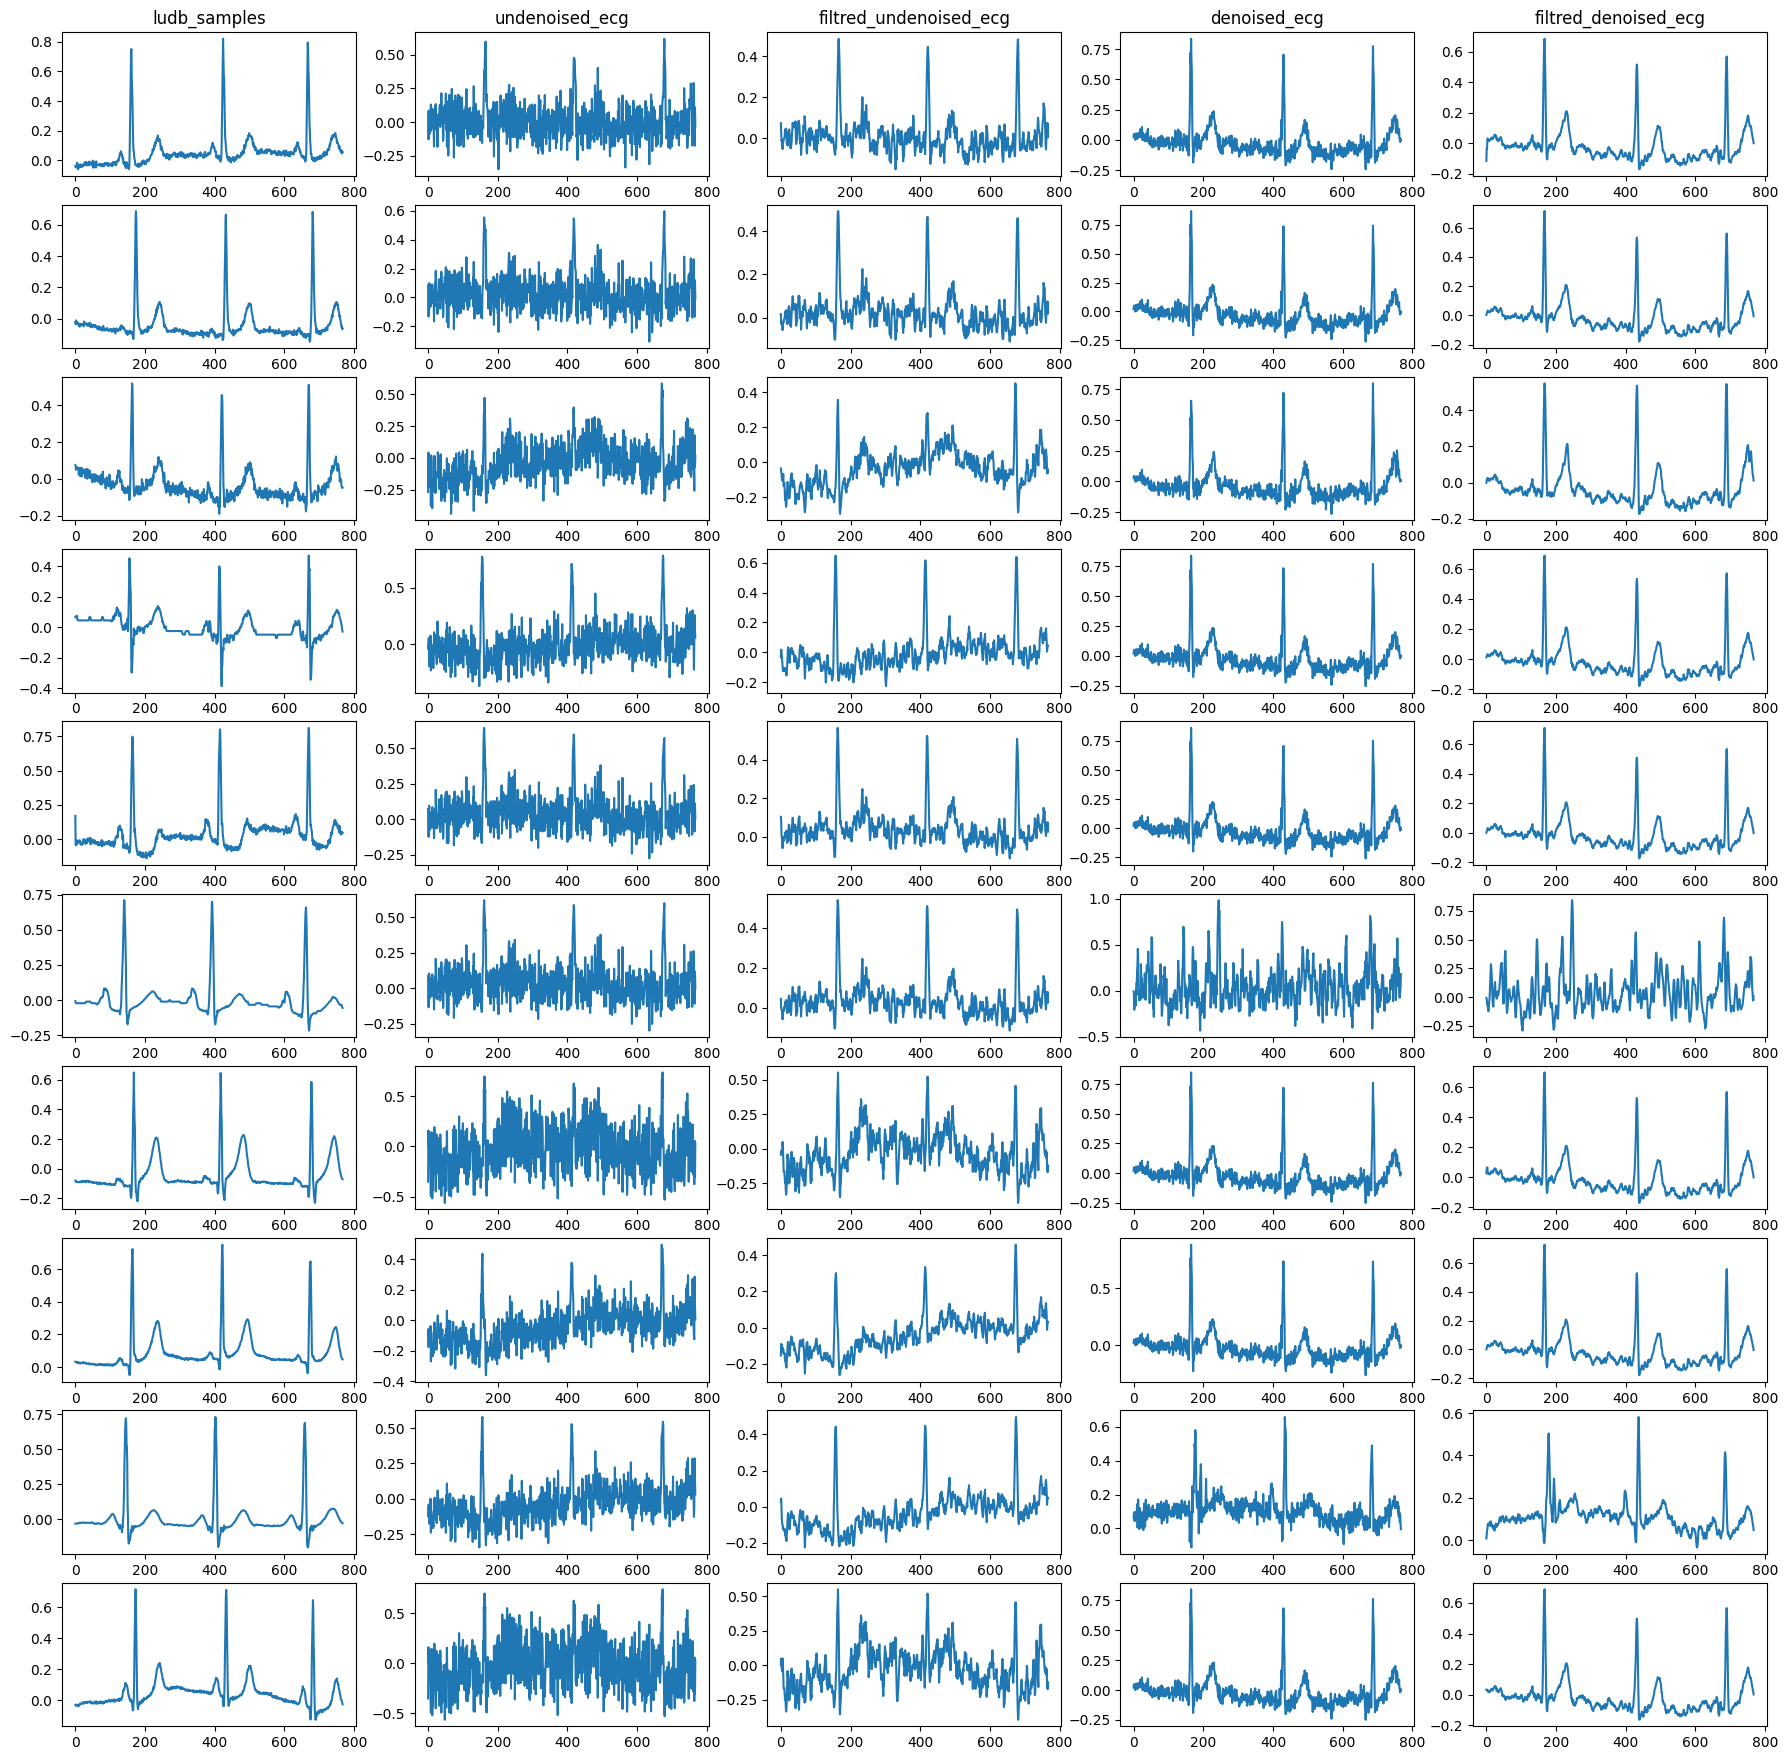

In [15]:
n_cols = 5
n_rows = num_samples

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22, 22))

axes[0, 0].set_title(f"ludb_samples")
axes[0, 1].set_title(f"undenoised_ecg")
axes[0, 2].set_title(f"filtred_undenoised_ecg")
axes[0, 3].set_title(f"denoised_ecg")
axes[0, 4].set_title(f"filtred_denoised_ecg")


for i in range(n_rows):
    axes[i, 0].plot(ludb_samples[i])
    axes[i, 1].plot(undenoised_ecg[i])
    axes[i, 2].plot(filtred_undenoised_ecg[i])
    axes[i, 3].plot(denoised_ecg[i])
    axes[i, 4].plot(filtred_denoised_ecg[i])

### Для слайдов

In [18]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

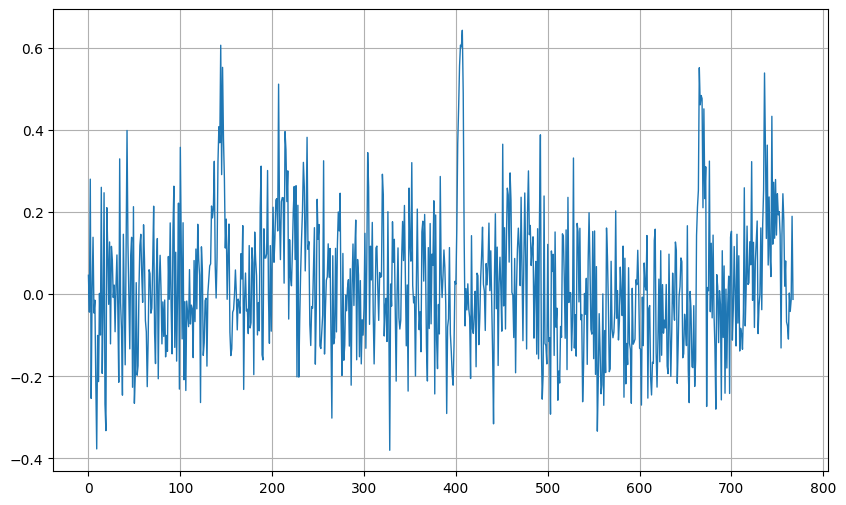

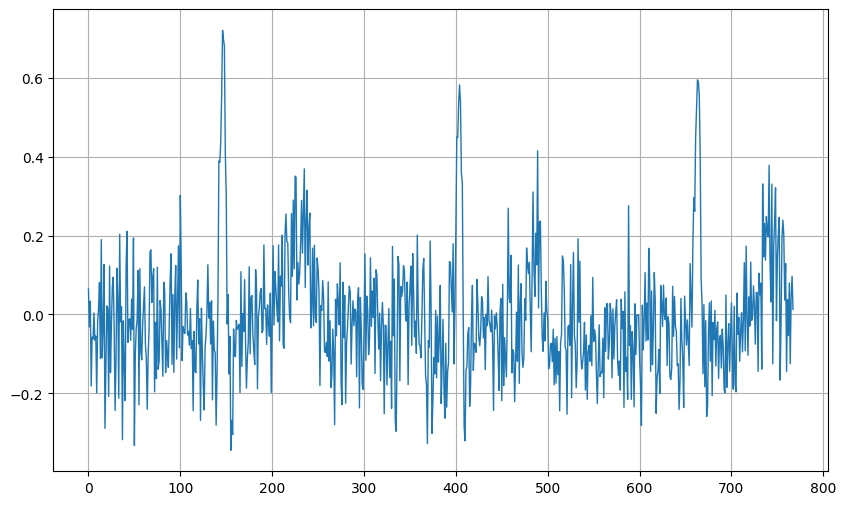

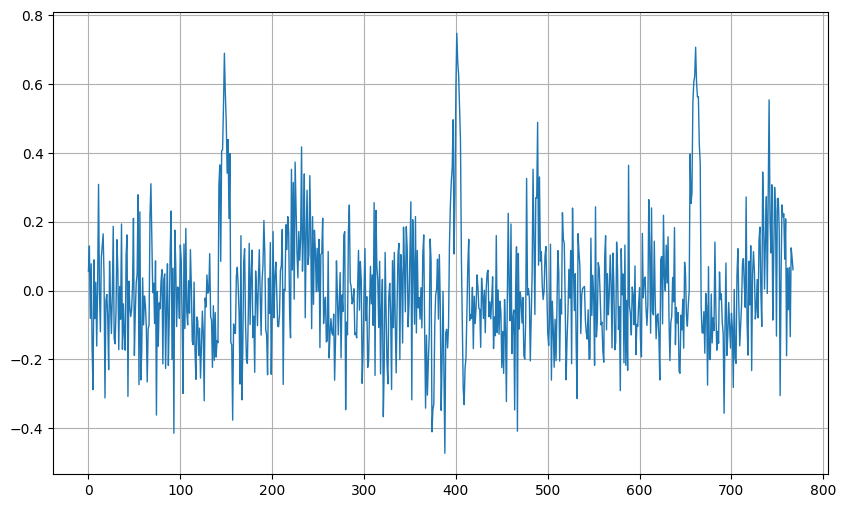

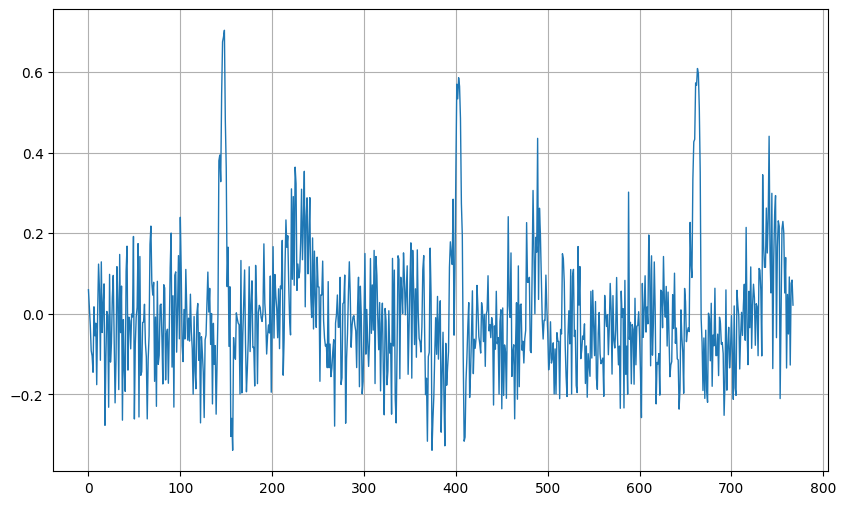

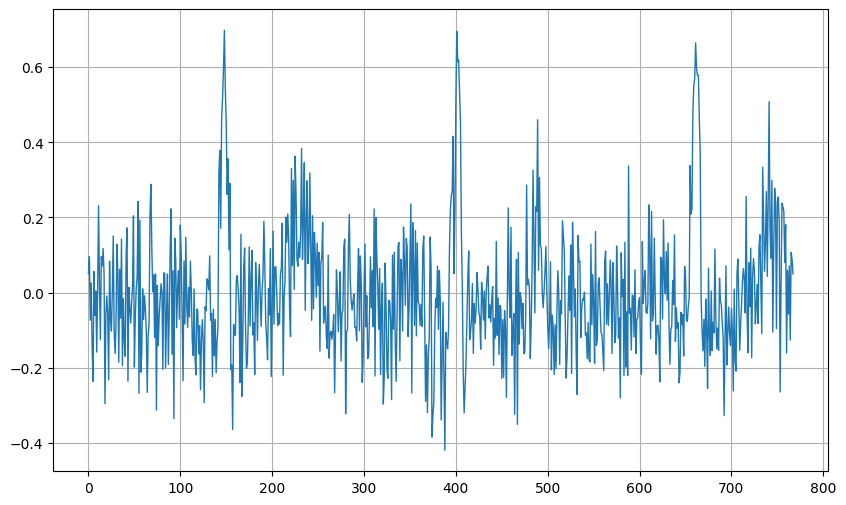

In [20]:
ludb_samples = random.choices(DATA["esg"], k=num_samples)
for i in undenoised_ecg:
    plt.figure()
    plt.plot(i)